In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload the file manually

import zipfile
import os

zip_path = "/content/archive.zip"  # Update with actual filename
extract_to = "/content/extracted_folder"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete!")

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
# Define paths
train_dir = '/content/drive/MyDrive/archive/AppleGradingData/Training'
test_dir = '/content/drive/MyDrive/archive/AppleGradingData/Testing'

In [4]:
# Set image parameters
img_width, img_height = 224, 224
batch_size = 32

In [5]:
# Create image generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

In [6]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 3911 images belonging to 4 classes.
Found 1154 images belonging to 4 classes.


In [7]:
# Get class names and number of classes
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Classes: {class_names}")

Classes: ['Apple Green', 'Apple Red G1', 'Apple Red G2', 'Apple Yellow G1']


In [8]:
# Build a CNN model using MobileNetV2 as base model (transfer learning)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# Create the model
model = Sequential([
    base_model,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [11]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,643,684 (10.08 MB)

 Trainable params: 385,700 (1.47 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the model
epochs = 20
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 1063s 9s/step - accuracy: 0.6214 - loss: 1.0830 - val_accuracy: 0.8090 - val_loss: 0.7070
Epoch 2/20
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:35 1s/step - accuracy: 0.8125 - loss: 0.5084

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


122/122 ━━━━━━━━━━━━━━━━━━━━ 59s 480ms/step - accuracy: 0.8125 - loss: 0.5084 - val_accuracy: 0.7908 - val_loss: 0.8308
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.9329 - loss: 0.1671 - val_accuracy: 0.8663 - val_loss: 0.5594
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 82s 665ms/step - accuracy: 0.9688 - loss: 0.1949 - val_accuracy: 0.8542 - val_loss: 0.7214
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.9608 - loss: 0.1171 - val_accuracy: 0.8568 - val_loss: 0.5944
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 573ms/step - accuracy: 0.9062 - loss: 0.3943 - val_accuracy: 0.8681 - val_loss: 0.5003
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.9662 - loss: 0.0938 - val_accuracy: 0.9280 - val_loss: 0.2459
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 82s 656ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 0.9332 - val_loss: 0.2455
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.9840 - loss: 0.0537 - val_accurac

In [14]:
# Train the model with corrected steps_per_epoch calculation
epochs = 20

# Calculate steps without integer division (use max to ensure at least 1 step)
train_steps = max(1, train_generator.samples // batch_size)
val_steps = max(1, test_generator.samples // batch_size)

# Reset generators to ensure they start from the beginning
train_generator.reset()
test_generator.reset()

# Add shuffle=True to ensure data is shuffled each epoch
train_generator.shuffle = True

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=val_steps,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 1297s 11s/step - accuracy: 0.6479 - loss: 1.0559 - val_accuracy: 0.8620 - val_loss: 0.3795
Epoch 2/20
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:45 1s/step - accuracy: 0.9062 - loss: 0.1488

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 470ms/step - accuracy: 0.9062 - loss: 0.1488 - val_accuracy: 0.8542 - val_loss: 0.4419
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9301 - loss: 0.1979 - val_accuracy: 0.8429 - val_loss: 0.7971
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 469ms/step - accuracy: 0.9375 - loss: 0.1746 - val_accuracy: 0.8524 - val_loss: 0.7367
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.9682 - loss: 0.0938 - val_accuracy: 0.8073 - val_loss: 0.7961
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 456ms/step - accuracy: 1.0000 - loss: 0.0566 - val_accuracy: 0.7899 - val_loss: 0.9752
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.9547 - loss: 0.1363 - val_accuracy: 0.9106 - val_loss: 0.3178
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 82s 669ms/step - accuracy: 0.9688 - loss: 0.1019 - val_accuracy: 0.9019 - val_loss: 0.3886
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.9783 - loss: 0.0757 - val_accurac

In [16]:
# Save the model
model.save('apple_grading_model.h5')

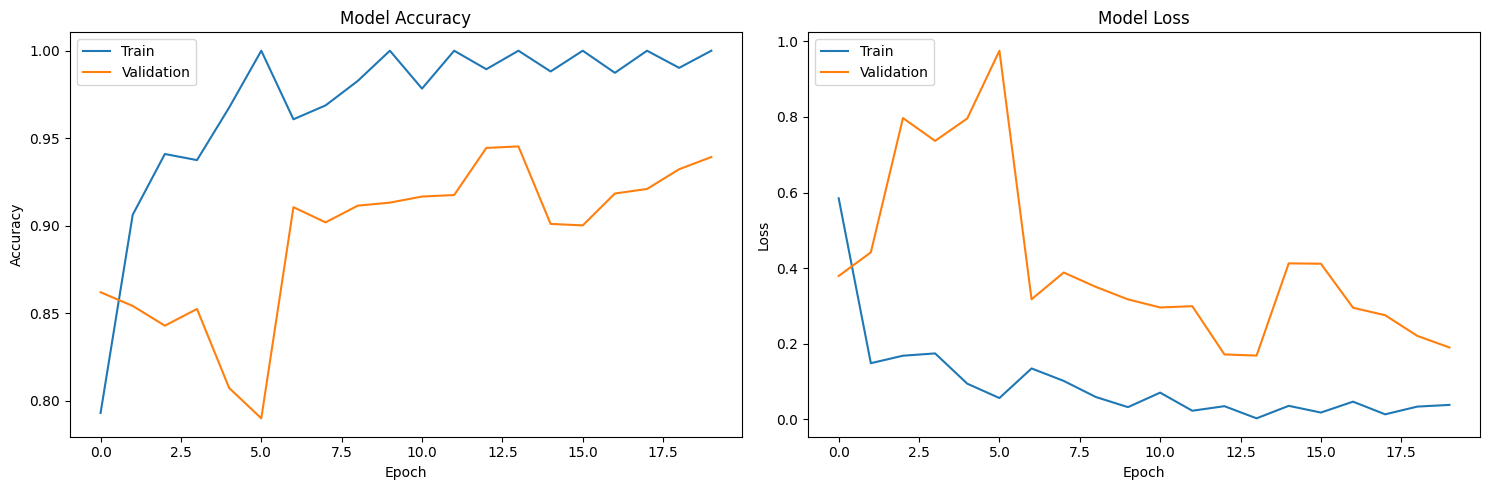

In [17]:
# Plot training & validation accuracy and loss
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

plot_training_history(history)

In [18]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Get predictions for the test set
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = test_generator.classes

37/37 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.9049 - loss: 0.3099
Test Accuracy: 0.9393
37/37 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step


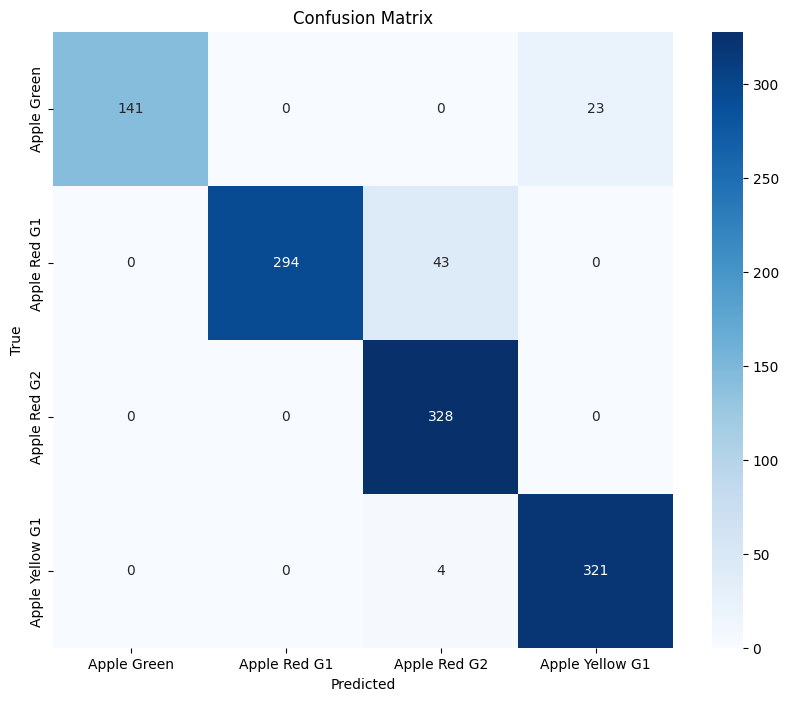


Classification Report:
                 precision    recall  f1-score   support

    Apple Green       1.00      0.86      0.92       164
   Apple Red G1       1.00      0.87      0.93       337
   Apple Red G2       0.87      1.00      0.93       328
Apple Yellow G1       0.93      0.99      0.96       325

       accuracy                           0.94      1154
      macro avg       0.95      0.93      0.94      1154
   weighted avg       0.95      0.94      0.94      1154



In [19]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

plot_confusion_matrix(y_true, y_pred, class_names)

In [20]:
# Function to predict grade for a new apple image
def predict_apple_grade(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale the same way as our training data

    # Make prediction
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class = class_names[predicted_class_index]
    confidence = prediction[0][predicted_class_index] * 100

    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class} (Confidence: {confidence:.2f}%)')
    plt.axis('off')
    plt.show()

    # Return results
    return {
        'grade': predicted_class,
        'confidence': confidence,
        'all_probabilities': {class_name: float(prediction[0][i])*100 for i, class_name in enumerate(class_names)}
    }

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


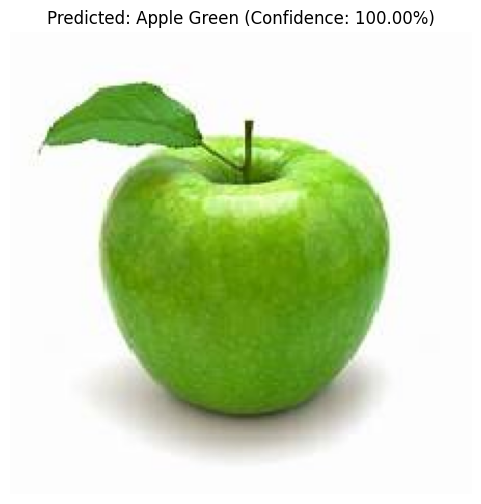

{'grade': 'Apple Green', 'confidence': np.float32(99.99998), 'all_probabilities': {'Apple Green': 99.99997615814209, 'Apple Red G1': 2.751472834294777e-09, 'Apple Red G2': 5.705311965459271e-13, 'Apple Yellow G1': 1.908225044644496e-05}}


In [22]:
# green apple test
result = predict_apple_grade('/content/green_test.jpeg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


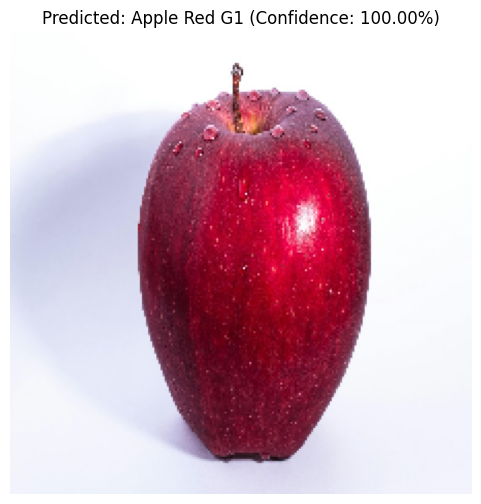

{'grade': 'Apple Red G1', 'confidence': np.float32(100.0), 'all_probabilities': {'Apple Green': 1.0902834455303167e-12, 'Apple Red G1': 100.0, 'Apple Red G2': 5.849101203381224e-07, 'Apple Yellow G1': 1.0581785674887738e-13}}


In [23]:
# good apple test
result = predict_apple_grade('/content/good_test.jpeg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


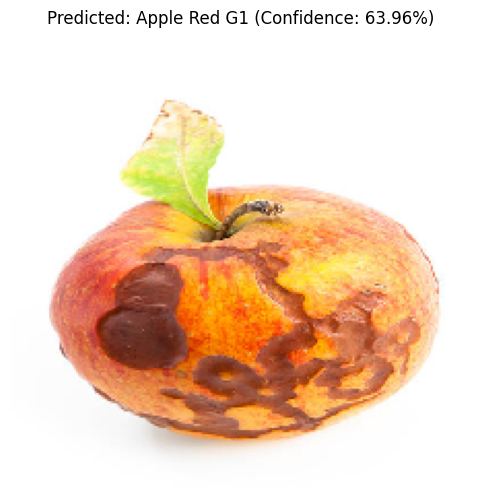

{'grade': 'Apple Red G1', 'confidence': np.float32(63.95756), 'all_probabilities': {'Apple Green': 5.727678164839745, 'Apple Red G1': 63.95756006240845, 'Apple Red G2': 26.78462862968445, 'Apple Yellow G1': 3.5301458090543747}}


In [24]:
# bad apple test
result = predict_apple_grade('/content/sample.jpeg')
print(result)